#**Progetto DSIM**
1. **Object Detection and Classification with** [YOLO3v](https://towardsdatascience.com/object-detection-using-yolov3-using-keras-80bf35e61ce1 )
2. **Extracting crops** 
3. **Describing every crop** with:
  - Identifier of original image
  - Label of the crop
  - Feature extracted on the crop
    - SIFT
    - VGG16 truncated
    - YOLO model truncated
  - Importance: $\frac{A_{crop}}{A_{image}}$ 
4. **Generating vectors** for each image

**NB**
>Per usare il metodo SIFT, prima di iniziare mandare i due codici citati nella sotto-sezione "SIFT" e reinizializzare il runtime.
<br>

> Caricare il modello coi pesi, eseguire il codice alla cella "Define hyperparameters and target lables" e partire direttamente dalla sezione 1.2



In [0]:
#Set tensorflow version

%tensorflow_version 1.x

In [0]:
#Import packages

import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.utils import plot_model
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, AveragePooling2D
from keras.models import load_model, Model
from keras.preprocessing import image
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

###**1. Object Detection and classification**

####**1.1 Re-create Yolo3v Model**

- Define class for reading the pre-trained weights of YOLO3v model obtained on "Coco" dataset:

In [0]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

- Create a function building the convolutional blocks, with or without skipping

In [0]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

- Recreate the YOLO3v model architecture

In [0]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

- Define hyperparameters and target lables

In [0]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


- Call the empy architecture able to predict 80 classes on COCO and load the pre-trained weights into the model

In [0]:
yolov3 = make_yolov3_model()

weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(yolov3)













loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of con

In [0]:
# Load the model

yolov3 = load_model("/content/yolov3.h5")

- Plot the final model

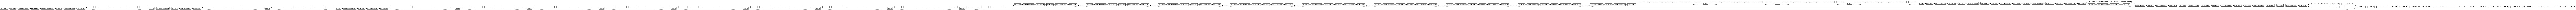

In [0]:
plot_model(yolov3, to_file='model.png',rankdir='LR')

####**1.2 Image Preprocessing**

We need a function loading and preparing images to be elaborated by the R-CNN:

In [0]:
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

####**1.3 Bounding boxes extraction and management**

In this section a class of functions is built for detecting target objects, identifying their location in the image through bounding boxes and computing their probability of actually belonging to the selected label - with a sigmoid function. The management of these boxes takes into account intersection over union (IoU) and the overlappings.
<br>
This class also consider a threshold of probability, beneath whom the bounding box is considered non maximal and thus suppressed. 

In [0]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

Then each NumPy array, one at a time, will be taken and the candidate bounding boxes and class predictions from the Yolov3 model will be decoded:


In [0]:
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

Bounding boxes will be stretched back into the shape of the original image, allowing the system to plot the original image and draw them above in order to detect real objects. Thus, `correct_yolo_boxes` corrects the sizes of the bounding boxes for the shape of the image:

In [0]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

Lastly, getting all of the results above a threshold,
the list of boxes, known labels, and the classification threshold as arguments, `get_boxes` will return a parallel lists of boxes, labels, and scores.


In [0]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

###**2. Cropping**

- Extracting coordinates of every labelled object

In [0]:
def get_coord_boxes(data,v_boxes,v_labels):
  l = []
  lab = []
  for i in range(len(v_boxes)):
    box = v_boxes[i]
    etichetta = v_labels[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    lab.append(etichetta)
    l.append([x1, y1, x2, y2])
  df = pd.DataFrame(
    {'Label': lab,
     'Coordinates': l
  })
  return df

- Cropping interesting object at the coordinates indicated by the YOLO3v bounding boxes

In [0]:
def extract_coord(photo_filename,class_threshold = 0.6,obj_thresh = 0.5):
  input_w, input_h = 416, 416
  net_h, net_w = 416, 416
  data = plt.imread(photo_filename)
  image, image_w, image_h = load_image_pixels(photo_filename, (net_w, net_w))
  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
  # make prediction
  yolos = yolov3.predict(image)
  # define the anchors
  boxes = list()
  for i in range(len(yolos)):
        # decode the output of the network
        boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)
  
  # correct the sizes of the bounding boxes
  correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)
  
  # suppress non-maximal boxes
  do_nms(boxes, nms_thresh)
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  print(boxes)
  dataframe = get_coord_boxes(data, v_boxes,v_labels)
  return dataframe

###**3. Crops description**

####**3.1 Feature extraction**

#####**3.1.1 SIFT**

**NB**: Per farlo funzione bisogna eseguire i seguenti codici e rinizializzare il runtime:
<br>
`!pip install opencv-python==3.4.2.16`
<br>
 `!pip install opencv-contrib-python==3.4.2.16`

In [0]:
def SIFT_extract(x,printed=False):
  sift = cv2.xfeatures2d.SIFT_create()
  (kps1, features1) = sift.detectAndCompute(x, None)
  if printed:
    _kps = cv2.drawKeypoints(x, kps1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(_kps); plt.show()
  return features1 #set of descriptors of dimensione 128 for each kp

**NB**: La similarità viene estratta applicando un [ratio test](https://python-forum.io/Thread-Score-of-similarity-using-SIFT-python) ai matches tra due immagini, ottenuti grazie alle features appena estratte: 

In [0]:
#Si crea il matcher
bf = cv2.BFMatcher(crossCheck=True)
#Si individuano i match
matches = bf.match(features1, features2)
#Si ordinano i matches
matches = sorted(matches, key=lambda x:x.distance)

#Si applica il ratio test
good = []
for m,n in matches:
  if m.distance < 0.75*n.distance:
    good.append([m])
    a=len(good)
    percent=(a*100)/len(kp2)
    print("{} % similarity".format(percent))
    if percent >= 75.00:
      print('Match Found')
    else:
      print('Match not Found')

#####**3.1.2 YOLO3v**

In [0]:
#Feature extraction with pooling

yolo_original = Model(inputs=yolov3.input, outputs=yolov3.get_layer("conv_103").output)
pool = AveragePooling2D()(yolo_original.output)
yolo_pooled = Model(inputs=yolov3.input, outputs=pool)

#In case one does not to pool the features vectors, the model to be used is "yolo_original"
#instead of "yolo_pooled"

def feature_extract_YOLO(x, model = yolo_pooled):
  x = Image.fromarray(x)
  x = x.resize((224,224), Image.ANTIALIAS)
  x = np.expand_dims(x, axis=0)
  f = model.predict(x) 
  return f.flatten() 

Using an Average Pooling method, the outputed vector will pass from a dimension of more than 1 mln to a dimension of 25088.

#####**3.1.1 VGG16**

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


def feature_extract_VGG16(x, model = VGG16(weights='imagenet', include_top=False, pooling='avg')):
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  features = model.predict(x)
  return features.flatten()

####**3.2 Importance**

In [0]:
def importance(original_image,x):
  box_width, box_height, channels = x.shape
  width, height = Image.open(original_image).size
  return((box_height* box_width)/(height*width))

<br>


In conclusion, we have this function:

In [0]:
def CropProcessing(image_path=None,mode=0):
  img = Image.open(image_path)
  ec = extract_coord(image_path)
  plots = []
  labels = []
  coord = []
  for i in range(len(ec)):
    img2 = img.crop(ec.loc[i]['Coordinates'])
    #Reshape image
    #img2.thumbnail(size, Image.ANTIALIAS)
    label = ec.loc[i]['Label']
    labels.append(label)
    plots.append(np.array(img2.convert('RGB')))
    coord.append(ec.loc[i]['Coordinates'])
    snd = list(dict.items(dict(zip(labels,plots))))
    
  for label in range(len(labels)):
    if mode == "SIFT":
      yield [image_path,snd[label][0],SIFT_extract(snd[label][1]),importance(image_path,snd[label][1])]
    elif mode == "YOLO":
      yield [image_path,snd[label][0],feature_extract_YOLO(snd[label][1]),importance(image_path,snd[label][1])]
    elif mode == "VGG":
      yield [image_path,snd[label][0],feature_extract_VGG16(snd[label][1]),importance(image_path,snd[label][1])]
    elif mode == 0: #Do not use any feature extraction method but return the crop
      yield [image_path,snd[label][0],snd[label][1],importance(image_path,snd[label][1])]

In [0]:
#Example with VGG16

example1 = list(CropProcessing("/content/A/bald-eagle.jpg",
                               mode = "VGG"))

In [0]:
#Showing the four separate descriptors for the crop
print('DESCRIPTORS:','\n')
print("ID ORIGINAL IMAGE:",example1[0][0],"\n") #Show the original image identificator
print("CROP LABEL:",example1[0][1],"\n") #Show the label
#print("FEATURE:",example1[0][2],"\n") #Show the array of feature from MobileNetV2
print("FEATURE SHAPE:",example1[0][2].shape,"\n")
print("IMPORTANCE:",example1[0][3]) #Show the importance score

DESCRIPTORS: 

ID ORIGINAL IMAGE: /content/A/bald-eagle.jpg 

CROP LABEL: bird 

FEATURE SHAPE: (512,) 

IMPORTANCE: 0.8861979166666667


Thus, in output will be return the list of these descriptors for each crop extracted from the original image.

###**4. Custom Data Loader**


Per ogni immagine:
  - Individua gli oggetti
  - Estrae ogni crop
    - Per ogni croop
      - Genera il vettore di descrittori

In [0]:
def image_generator(directory, mode):
  files = os.listdir(directory)
  namefile = [os.path.join(directory, file) for file in files]
  res = []
  for i in range(len(namefile)-1):
    res.append(list(CropProcessing(lista_foto[i],mode)))
  return res

In [0]:
#Esempio con YOLO

x1 = image_generator("/content/A", mode="YOLO")

In [0]:
x1 #List of the four describers of all crops belonging to every image in the directory "A"

[[['/content/A/7813143-an-attractive-girl-on-a-motorbike-posing-outside.jpg',
   'person',
   array([ 0.20216084, -1.6861835 , -4.8889465 , ..., -3.5014095 ,
           2.0206869 , -1.8274347 ], dtype=float32),
   0.3618227038550364],
  ['/content/A/7813143-an-attractive-girl-on-a-motorbike-posing-outside.jpg',
   'motorbike',
   array([-5.714272  ,  2.6650171 ,  0.02774349, ..., -1.7611581 ,
           0.6556478 ,  2.1176286 ], dtype=float32),
   0.7021922188665838]],
 [['/content/A/Can-I-feed-my-cat-pizza.jpg',
   'dog',
   array([-14.067779 ,   2.2033362,  -3.1414616, ...,  -6.40446  ,
            7.188436 ,  -4.617824 ], dtype=float32),
   0.687675],
  ['/content/A/Can-I-feed-my-cat-pizza.jpg',
   'pizza',
   array([-15.978085 ,   2.8840916,  -8.582373 , ...,  -1.4949822,
            1.1208789,   1.231042 ], dtype=float32),
   0.43365]],
 [['/content/A/bald-eagle.jpg',
   'bird',
   array([-15.440363 ,   4.017091 ,  -1.5805658, ...,  -3.3268347,
           -8.152475 , -13.766306 ],